In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import cv2, keras
import tensorflow as tf
import PIL
from PIL import Image

import os
import random
import warnings
warnings.filterwarnings("ignore")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
train_path = 'C:/Users/shrey/Desktop/Ann/training_images'
annot = 'C:/Users/shrey/Desktop/Ann/train_solution_bounding_boxes (1).csv'
labels = pd.read_csv(annot)
labels.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [3]:
# Plot Images with annot 
def display_image(path, box=None, specific=False): 
    print(int(box['xmin']), int(box['ymin']), int(box['xmax']-box['xmin']), int(box['ymax']-box['ymin']))
    
    if not specific:
        plt.imshow(Image.open(path))
        img = Image.open(path)
        fig, ax = plt.subplots()
        ax.imshow(img)
        rect = patches.Rectangle((int(box['xmin']), int(box['ymin'])), int(box['xmax']-box['xmin']), int(box['ymax']-box['ymin']), linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.show()
    else:
        plt.imshow(path)
        fig, ax = plt.subplots()
        ax.imshow(path)
        for i in box:
            rect = patches.Rectangle((int(i[0]-(i[2]/2)), int(i[1]-(i[3]/2))), int(i[2]), int(i[3]), linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        plt.show()

281 187 46 36


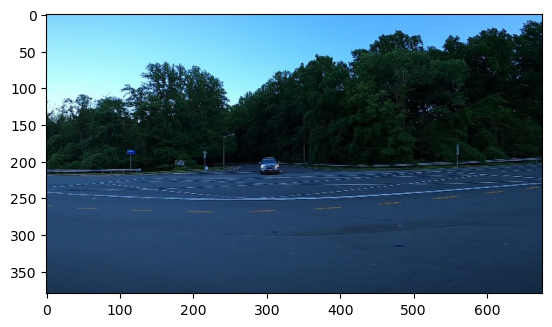

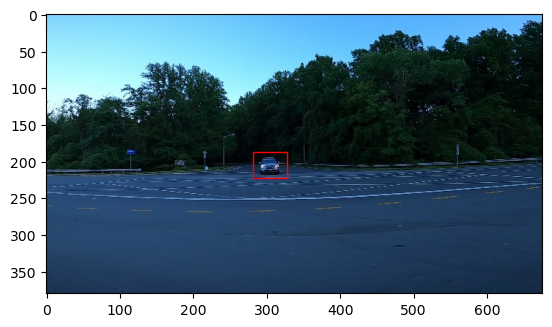

In [4]:
display_image(train_path + '/' + labels['image'][0], labels[0:1])

In [5]:
cv2.setUseOptimized(True);
# Create a Selective Search segmentation object
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()


AttributeError: module 'cv2' has no attribute 'ximgproc'

In [ ]:
# Get Intersection over Union computed by selective search
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
train_images = []
train_labels = []

In [ ]:
for i in range(len(labels)):
    image = cv2.imread(train_path + '/' + labels['image'][i])
    image = np.array(Image.open(train_path + '/' + labels['image'][i]))
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    print(f'[{i}] {labels["image"][i]} {ssresults.shape}')
    imout = image.copy()
    counter = 0
    falsecounter = 0
    flag = 0
    fflag = 0
    bflag = 0
    gtval = {"x1":labels.iloc[i]['xmin'].item(),"x2":labels.iloc[i]['xmax'].item(),"y1":labels.iloc[i]['ymin'].item(),"y2":labels.iloc[i]['ymax'].item()}
    for e, result in enumerate(ssresults):
        if e < 2000 and flag == 0:
            x,y,w,h = result
            iou = get_iou(gtval, {"x1":x,"x2":x+w,"y1":y,"y2":y+h})
            if counter < 7:
                if iou > 0.50:
                    timage = image[y:y+h,x:x+w]
                    resized = cv2.resize(timage, (224, 224), interpolation = cv2.INTER_AREA)
                    train_images.append(resized)
                    train_labels.append(1)
                    counter += 1
            else:
                fflag = 1
            if falsecounter < 5:
                if iou < 0.3:
                    timage = image[y:y+h,x:x+w]
                    resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                    train_images.append(resized)
                    train_labels.append(0)
                    falsecounter += 1
            else:
                bflag = 1
            if fflag == 1 and bflag == 1:
                print("inside")
                flag = 1

    print(f'train_images: {len(train_images)}, 1: {counter}, 0: {falsecounter}')


In [ ]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [ ]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [ ]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

In [ ]:
X = vggmodel.layers[-2].output

In [ ]:
predictions = Dense(2, activation='softmax')(X)

In [ ]:
model_final = Model(vggmodel.input, predictions)

In [ ]:
from keras.optimizers import Adam
opt = Adam(learning_rate=0.0001)

In [ ]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

In [ ]:
model_final.summary()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [ ]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [ ]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [ ]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [ ]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

In [ ]:
plt.imshow(X_train[0])

In [ ]:
y_train

In [ ]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [ ]:
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 20, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

In [ ]:
model_final.save('')

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["accuracy","Validation Loss","Loss"])
plt.show()
plt.savefig('chart loss.png')

In [ ]:
import random

im = X_test[random.randint(0, 218)]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("Car")
else:
    print("not Car")

In [ ]:
im = X_test[random.randint(0, 218)]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("Car")
else:
    print("not Car")

In [ ]:
im = X_test[random.randint(0, 218)]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("Car")
else:
    print("not Car")